# Covid-19 Pandemic and Polarity in Editorial News: A BBC study case

## Introduction

The Covid-19 pandemic affeted the world well beyond the numbers which have become an unpleasant but inevitable part of our daily lives - infection incidence, deaths, vaccination coverage. As we slowly but steadily approach a new time of relative normality, we believe that there may be hidden patterns in our society whose importance might have been obscured by the urgency and hardship of the pandemic. We propose to apply Natural Language Processing (NLP) to content created and shared on the internet before and during the pandemic in order to extract its polarity over time and statistically determine whether there was a significant change since the pandemic started.

Polarity is essentially a part of sentiment analysis. More specifically, it is a feature offered by the SpaCy library in order to determine the positivity or negativity of a statement (https://ieeexplore.ieee.org/document/9197829). It is extracted as a metric for a string of any arbitrary size, and the output corresponds to the average of the polarity of all text in the document. It is a float which lies in the range -1 to 1.

The corpus of text that we will collect, process, and analyse comprises of a sample of articles from the archive of the British Broadcasting Corporation (BBC). Our choice for BBC is due to it being a public entity, one of the largest broadcasters in the world, and highly regarded (https://publications.parliament.uk/pa/ld200506/ldselect/ldbbc/50/5005.htm); the content is free to be accessed and made available via an archive sitemap listed on the website's [robots.txt](https://www.bbc.co.uk/robots.txt) file. This makes possible for us to explore the variation of polarity over time.

We will work with a sample of the data because processing all the available data - news articles from BBC since 2010 - would not be viable in a home computer due to the size of the data associated with time and submission constraints. The limit of pages to be crawled from each plain sitemap is a parameter of our sitemap crawler. Nonetheless, the number of documents is still significantly large, therefore we make the assumption that they represent the population of documents - and discuss this decision in the Conclusion. 

Our null hypothesis states that there is no significant change in the polarity of BBC articles since the pandemic started. The alternative hypothesis states that there is a significant change. We will apply significance tests to the extracted polarity over time in order to test the hypothesis. Furthermore, we will consider different scenarios that could be formulated as sub-hypotheses which refer to each of the metrics relative to the pandemic (new infections, hospital admissions etc.). 

## Import libraries

In [2]:
import requests
import re
import urllib
from urllib.parse import urlparse
from urllib.request import urlopen
import collections
import json
from lxml import etree
import pandas as pd
import spacy
from spacytextblob.spacytextblob import SpacyTextBlob
from datetime import datetime
import unittest
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter, MonthLocator
import numpy as np
from scipy.stats import ttest_1samp

nlp = spacy.load("en_core_web_sm")
nlp.add_pipe('spacytextblob')

## Data Gathering

Our starting point is the URL https://www.bbc.co.uk/sitemaps/https-index-uk-archive.xml. It contains an archive with the BBC content published online since 2010 up to the current date. We will first capture all URLs of interest and then visit each URL.

Firstly we declare a new class `SitemapWebCrawler` in order to contain the logic for extracting the URLs of a sitemap, with a couple elements designed specifically for the BBC sitemap. 

We use the `collections` library to create a `defaultdict`, which we can manipulate easily. This will be populated and then saved as JSON output in the end. We also create a queue (a `deque`) from the `collections` library to manage the enqueuing of URLs. A set `visited` serves as lookup to know if we already visited a URL. The webcrawler pops (selects and removes from it) the leftmost URL from the queue, whose links are then extracted. 

For each element in the result, we extract the URL and the publish date, and, if the URL has not yet been visited, it is added to the end of the queue. The process repeats until the queue is empty. One of the features introduced after some iterative development is a limit of visited URLs per sitemap via the `limit_urls` parameter. This has been added after the assessment that crawling the entire archive sitemap is not feasible.

The date is purposefully extracted in this step. We get it from the `lastmod` tag in the sitemap next to its corresponding `loc` node, where the URL can be found. The reason for this is that it is not possible to extract the date consistently from the body of all the BBC articles using only one or two XPath expressions. The timestamp is the next best option available to extract the date in which the article was published - technically, in which the file was last modified, which in this case should have a negligible effect. A limit of about 160 URLs per sitemap is the limit in order for the output to be smaller than 10MB, as required for sharing.

In [3]:
class SitemapWebCrawler():
    
    # start_url: initial URL to crawl
    # limit_urls: upper limit of URLs to visit per sitemap
    # output_file_name: name of a JSON file with the resulting URLs
    
    def __init__(self, start_url, limit_urls, output_file_name):
        self.output_file_name = output_file_name
        self.start_url = start_url
        self.visited = set()
        self.limit_urls = limit_urls

    def get_xml(self, url):
        # request the URL and return its contents
        try:
            response = requests.get(url)
        # an exception handler here avoids that the program breaks in case it cannot visit a URL
        except urllib.error.HTTPError as e:
            print(f'{e}\n{url}\n')
            return ""
        return response.text

    def get_links(self, url):
        # URL is requested calling `get_xml()` method
        try:
            xml = self.get_xml(url)
            # links are searched in the crawled page using a regular expression that returns 'href' values of <a> nodes
            links = re.findall('<loc>(.*?)<\/loc>', xml)
            dates = re.findall('<lastmod>(.*?)<\/lastmod>', xml)
            # the method returns a DataFrame that contains article publish date and URL
            df = pd.DataFrame([dates, links]).T.rename(columns={0:'date', 1:'url'})
            return df[:self.limit_urls]
        except urllib.error.HTTPError as e:
            print(f'{e}\n{url}\n')
            return ""

    def crawl(self, start_url):
        data = collections.defaultdict(dict)
        # it is enqueued and added to the visited urls
        queue = collections.deque([start_url])
        self.visited.add(start_url)
        counter = 0

        # the crawling will carry on as long as the queue is not empty - limited to 'max_depth'
        while queue:
            # the URL to the left of the queue is popped and checked for depth
            v = queue.popleft()
            # 'get_links()' method is called to extract the links
            urls = self.get_links(v)
            for i, row in enumerate(urls.iterrows()):
                url = row[1][1]
                date = row[1][0]
                if url not in self.visited:
                    counter += 1
                    self.visited.add(url)
                    queue.append(url)
                    # assemble the dictionary 'data'
                    data[counter]['url'] = url
                    data[counter]['date']= date

        # results are saved to 'data.json'
        with open(f'{self.output_file_name}.json', 'w', encoding='utf-8') as file:
            json.dump(data, file, indent=4)
            file.close()
        print('\nCrawling finished successfully!\n')

    def start(self):
        self.crawl(self.start_url)

### Crawl the links

Here we crawl with a `limit_urls` parameter set to 160. This will yield 39 sitemap URL and 6240 article URLs; and it will keep the size of the processed data (after the `process` function below) under 10MB. It has been saved as `data.json`.  For reproduction purposes, we recommend running it with a limit set to 5 or 10 maximum due to time constraints (pre-named below as `data_reproduction.json`).

In [4]:
# Create an instance of the SitemapWebCrawler and call the `start` method

crawler = SitemapWebCrawler('https://www.bbc.co.uk/sitemaps/https-index-uk-archive.xml', 5, 'data_reproduction')
crawler.start()


Crawling finished successfully!



### Read in result

Below we read in the dictionary produced by the link extraction. We then filter the data for article URLs only, using a compiled regular expression (based on observation) and visit each article URL. We get the result as an `ElementTree` from the `xml` built-in library. The XML tree structure makes navigation relatively simple with the use of XPath. Based once again on observations, we use XPath expressions to extract both the title and the content (corpus) of every article. 

In [4]:
# Read the dictionary as CSV

with open('data.json', encoding='utf-8') as file:
    df = pd.read_json(file, orient='index')
    file.close()

In [5]:
# Compile regular expression to filter for artile URLs
article_url_regex = re.compile('.+\d{8,}')

# Filter DataFrame
data = df[df.url.str.contains(article_url_regex)]

In [6]:
data.tail()

,url,date
6275,https://www.bbc.co.uk/news/uk-wales-57308495,2021-05-31 14:53:38+00:00
6276,https://www.bbc.co.uk/sport/olympics/57410179,2021-06-09 10:04:25+00:00
6277,https://www.bbc.co.uk/news/uk-england-bristol-...,2021-06-09 10:17:18+00:00
6278,https://www.bbc.co.uk/sport/av/football/57932118,2021-07-22 13:07:20+00:00
6279,https://www.bbc.co.uk/news/uk-england-derbyshi...,2021-06-17 16:22:49+00:00


We create XPath expressions - based on observation - to extract the content and the title of the articles. We then declare a `process` function, to be applied in a `DataFrame`. It contains the logic of visiting a URL to retrieve the `root` of the `ElementTree` in the `get_document` function; and to extract, from the returned `root`, both the content and title in the `extract` function. The iteration over the URLs and saving the data to a new `DataFrame` is done internally to the `process` function. For every visited URL, after extracting article parts, we apply the `nlp` function from `SpaCy` on the content. This is an essential part of the process, as it gives us access to the polarity of the text.

In [7]:
content_xpath = '//article/div[@data-component="text-block"]//*'
title_xpath = '//h1'

In [8]:
def process(df):
    # create an empty DataFrame to store the retrieved and processed data
    data = pd.DataFrame(columns=['url', 'date', 'title', 'content', 'polarity'])

    def get_document(url):
        
        try:
            # send a request to the URL
            response = urlopen(url)
            # create an HTML parser
            htmlparser = etree.HTMLParser()
            # parse the response as an ElementTree
            tree = etree.parse(response, htmlparser)
            # extract the root of the tree and return it
            root = tree.getroot()
            return root
        
        except urllib.error.HTTPError as e:
            print(f'{e}\n{url}\n')
            return ""

    def extract(root, xpath_expression):
        # extract the text from each tree element returned by the XPath expression (if the text is not empty)
        content = [elem.text for elem in root.xpath(xpath_expression) if elem.text is not None]
        # transform the result in a string and return it
        text_string = ' '.join(content)
        return text_string

    # download and extract each article URL
    
    for i, row in enumerate(df.iterrows()):
        article_url = row[1][0]
        date = row[1][1]
        # download the article contents
        article = get_document(article_url)
        # skip if the article is empty
        if len(article) == 0:
            continue
        
        # extract the article areas (content and title)
        title = extract(article, title_xpath)
        content = extract(article, content_xpath)
        
        # skip if the content is empty
        if len(content) == 0:
            continue

        # apply NLP function
        doc = nlp(content)
        # extract polarity
        polarity = doc._.polarity
        # assemble row to add to the DataFrame
        row = [article_url, date, title, content, polarity]
        # add the row to the end of the DataFrame
        data.loc[len(data)] = row

    return data

We run the `process` function, which prints out HTTP errors with the corresponding document URL in case of failure.

In [9]:
# This can be run on a sample of the data
# processed_data = process(data.sample(100))

processed_data = process(data)

HTTP Error 404: Not Found
https://www.bbc.co.uk/sport/football/12734066

HTTP Error 404: Not Found
https://www.bbc.co.uk/sport/football/12733939

HTTP Error 404: Not Found
https://www.bbc.co.uk/news/magazine-26980359



In [11]:
processed_data.head()

,url,date,title,content,polarity
0,https://www.bbc.co.uk/news/uk-england-manchest...,2010-09-22 17:35:34+00:00,Manchester soldier's last words become song,The final words written by a guardsman killed ...,0.127435
1,https://www.bbc.co.uk/news/world-asia-pacific-...,2010-10-12 08:54:42+00:00,North Korea leader's eldest son 'opposes dynasty',The eldest son of North Korean leader Kim Jong...,0.013636
2,https://www.bbc.co.uk/news/health-10869329,2010-08-06 02:46:40+00:00,Why quitting heroin substitute methadone is 'v...,The heroin substitute methadone can be used as...,0.138417
3,https://www.bbc.co.uk/news/uk-england-lincolns...,2010-10-27 17:35:24+00:00,Paintings by gangster Reggie Kray go on sale i...,Seven oil paintings created by notorious gangs...,-0.006548
4,https://www.bbc.co.uk/news/uk-england-hereford...,2010-09-13 12:49:34+00:00,Teacher jailed for under-age sex in Worcesters...,A teacher has been jailed for four years after...,0.034028


In [14]:
# Save the result as a CSV checkpoint
# processed_data.to_csv('processed_data.csv')

### Read in processed data

In [48]:
# Read in the result
processed_data = pd.read_csv('processed_data.csv', index_col=None, 
                            usecols=['url', 'date', 'title', 'content', 'polarity'])
# Make a copy of the data to work with
df = processed_data.copy()

# Transform the date column in a Datetime object, extract the date 
# only up to the day and overwrite the time information
df['date'] = pd.to_datetime(df['date']).dt.date

In [49]:
df.head()

,url,date,title,content,polarity
0,https://www.bbc.co.uk/news/uk-england-manchest...,2010-09-22,Manchester soldier's last words become song,The final words written by a guardsman killed ...,0.127435
1,https://www.bbc.co.uk/news/world-asia-pacific-...,2010-10-12,North Korea leader's eldest son 'opposes dynasty',The eldest son of North Korean leader Kim Jong...,0.013636
2,https://www.bbc.co.uk/news/health-10869329,2010-08-06,Why quitting heroin substitute methadone is 'v...,The heroin substitute methadone can be used as...,0.138417
3,https://www.bbc.co.uk/news/uk-england-lincolns...,2010-10-27,Paintings by gangster Reggie Kray go on sale i...,Seven oil paintings created by notorious gangs...,-0.006548
4,https://www.bbc.co.uk/news/uk-england-hereford...,2010-09-13,Teacher jailed for under-age sex in Worcesters...,A teacher has been jailed for four years after...,0.034028


Now we are ready to read-in the official Covid-19 data for the UK, available under https://coronavirus.data.gov.uk/details/download. The data set is included in the coursework submission, but it can also be downloaded under [this link](https://api.coronavirus.data.gov.uk/v2/data?areaType=overview&metric=hospitalCases&metric=newAdmissions&metric=newCasesBySpecimenDate&metric=newDailyNsoDeathsByDeathDate&metric=newPeopleVaccinatedCompleteByPublishDate&format=csv) - it should be named `covid.csv`. We will replace the `NaN` values with 0, which is present when there is no value collected; `NaN` here mostly means that the metric does not apply (e.g. there could not be any number of vaccinated people before the vaccines were deployed).

The columns in the data are the following:
- "date": the date to which the row refers;
- "hospitalCases": the total number of patients in the hospital;
- "newAdmissions": new daily admissions to the hospital;
- "newCasesBySpecimenDate": new Covid-19 infections by specimen date;
- "newDailyNsoDeathsByDeathDate": new daily deaths;
- "newPeopleVaccinatedCompleteByPublishDate": new daily vaccinations.

In [13]:
# Read in data downloaded from https://coronavirus.data.gov.uk/details/download
covid_data = pd.read_csv('covid.csv', index_col=None).fillna(0).drop(columns=['areaCode', 'areaName', 'areaType'])

# Convert numeric columns from float to int
covid_data.iloc[:, 1:] = covid_data.iloc[:, 1:].astype(int)

# Convert the `date` column into Datetime object
covid_data['date'] = pd.to_datetime(covid_data['date']).dt.date

In [14]:
covid_data.sample(3)

,date,hospitalCases,newAdmissions,newCasesBySpecimenDate,newDailyNsoDeathsByDeathDate,newPeopleVaccinatedCompleteByPublishDate
66,2021-06-27,1602,265,18125,23,123555
262,2020-12-13,17538,1755,21983,480,0
103,2021-05-21,922,124,2293,18,426683


## Unit Testing

In this part, we take the opportunity to run some unit tests. They have been put together in this section for ease of usage.

We test whether the `SitemapWebCrawler` defined above returns empty in case the start URL does not exist. We also test the `process` function: whether 1) a broken URL and 2) a valid URL with no extracted content correctly return empty (and the resulting `DataFrame` has therefore length 0).

In [15]:
class TestSitemapWebCrawler(unittest.TestCase):
    
    def test_non_existing_url_returns_empty(self):
        crawler = SitemapWebCrawler('https://www.bbc.co.uk/sitemaps/this-is-a-fake-url.xml', 1, 'test')
        self.assertIsNone(crawler.start())

In [16]:
class TestProcessing(unittest.TestCase):
    
    def setUp(self):
        self.mock_df = pd.DataFrame({'url': ['https://www.bbc.co.uk/news/this-is-a-fake-url',
                                    'https://www.bbc.com/news/av/world-south-asia-10805458'],
                                    'date': ['2021-04-21 06:51:48+00:00', '2010-07-29 14:29:37+00:00']})
    
    def test_non_existing_url_returns_empty(self):
        self.assertEqual(len(process(self.mock_df.iloc[[0]])), 0) # call the function only on the first row
        
    def test_document_with_no_content_extracted_returns_empty(self):
        self.assertEqual(len(process(self.mock_df.iloc[[1]])), 0) # call the function only on the second row

In [17]:
unittest.main(argv=['ignored', '-v'], exit=False)

test_document_with_no_content_extracted_returns_empty (__main__.TestProcessing) ... /Users/felipemarineli/opt/anaconda3/envs/data_programming/lib/python3.8/site-packages/pandas/core/indexes/base.py:395: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif issubclass(data.dtype.type, np.bool) or is_bool_dtype(data):
ok
test_non_existing_url_returns_empty (__main__.TestProcessing) ... ok
test_non_existing_url_returns_empty (__main__.TestSitemapWebCrawler) ... 

HTTP Error 404: Not Found
https://www.bbc.co.uk/news/this-is-a-fake-url


Crawling finished successfully!



ok

----------------------------------------------------------------------
Ran 3 tests in 0.743s

OK


Our tests run as expected, and we can confidently move on to the data analysis.

## Data Analysis

Now we are ready to visualize the data in order to get some insights about it. Rather than specific news articles, we are interested in the polarity grouped by date. This will give us a good measure for polarity variation over time. Below we extract the average polarity by day. We then remove outliers from the data - perhaps days in which there was only one article with extreme polarity in either direction; we keep the records that are within three standard deviations from the mean. Then we group the data by week in order to visualize it in a more intuitive way on the plots. 

In [18]:
# Store the mean polarity by day in order to plot the change over time
daily_polarity = pd.DataFrame(df.groupby(df["date"])["polarity"].mean()).reset_index()
print(f"Data length before normalization: {len(daily_polarity)}")

# Keep only the days in which the polarity is within 3 standard deviations from the mean
daily_polarity = daily_polarity[np.abs(daily_polarity["polarity"] - daily_polarity["polarity"].mean()) <= (3 * daily_polarity["polarity"].std())]

print(f"Data length after normalization: {len(daily_polarity)}")

Data length before normalization: 1611
Data length after normalization: 1594


In [19]:
# Group the data by week, taking the mean polarity, in order to have a clearer grapth (less data points)
weekly_polarity = daily_polarity.copy()
weekly_polarity['date'] = pd.to_datetime(weekly_polarity['date']) - pd.to_timedelta(7, unit='d')
weekly_polarity = pd.DataFrame(weekly_polarity.groupby([pd.Grouper(key='date', freq='W')])['polarity']\
                                            .mean().reset_index().sort_values('date').dropna(subset=['polarity']))
weekly_polarity.head()

,date,polarity
0,2010-05-02,0.155864
1,2010-05-09,0.064869
2,2010-05-16,0.048148
4,2010-05-30,0.085370
9,2010-07-04,-0.025000


We first would like to see the evolution of document polarity over time. For this, we plot the week polarity in a time series.

/var/folders/pc/wdlmxwxj27d3wwj5bfsjlkbh0000gn/T/ipykernel_12159/3486047181.py:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show();


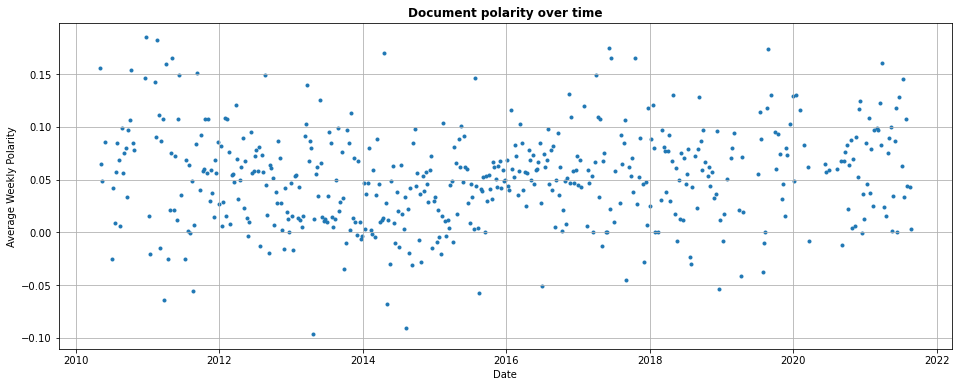

In [20]:
# TODO: draw graph properly

fig, ax = plt.subplots(figsize=(16, 6))
ax.scatter(weekly_polarity.date, weekly_polarity.polarity, marker='.')
ax.set_title(f'Document polarity over time', fontweight='bold')
ax.set_xlabel('Date')
ax.set_ylabel('Average Weekly Polarity')
ax.grid()
fig.show();

In a first glance, the graph does not seem to demonstrate a meaningful variation of polarity in the pandemic; if anything, the polarity seems to have gone up. We would like to investigate it further by looking at the polarity associated with Covid-19 metrics. 

In [21]:
final_df = daily_polarity.merge(covid_data, on='date', how='left').fillna(0)
final_df.iloc[:, 2:] = final_df.iloc[:, 2:].astype(int)
final_df = final_df.sort_values(by='date', ascending=False)

In [22]:
final_df.head()

,date,polarity,hospitalCases,newAdmissions,newCasesBySpecimenDate,newDailyNsoDeathsByDeathDate,newPeopleVaccinatedCompleteByPublishDate
1593,2021-08-26,-0.061972,6996,949,36911,0,144936
1592,2021-08-24,0.067673,6932,985,36942,0,130676
1591,2021-08-17,0.043062,6393,961,37077,78,145875
1590,2021-08-08,-0.040540,5845,741,22360,80,122070
1589,2021-08-05,0.127906,5745,805,31025,95,172692


In [23]:
final_df.describe()

,polarity,hospitalCases,newAdmissions,newCasesBySpecimenDate,newDailyNsoDeathsByDeathDate,newPeopleVaccinatedCompleteByPublishDate
count,1594.000000,1594.000000,1594.000000,1594.000000,1594.000000,1594.000000
mean,0.048672,519.459849,54.447930,796.072146,14.706399,5661.672522
std,0.067876,3330.509682,335.972113,4616.170516,104.076088,41773.662866
min,-0.166667,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.005980,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.051574,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.090859,0.000000,0.000000,0.000000,0.000000,0.000000
max,0.264049,38846.000000,4161.000000,46973.000000,1484.000000,556951.000000


In order to plot the metrics on interest, we declare a function below named `plot_polarity` which was custom designed to our specific needs.

In [24]:
def plot_polarity(column_name, initial_date, label):
    
    # "column_name": the metric of interest from the 'covid_data' data set
    # "initial_date": the initial date of the time series; it must be in 'YYYY-MM-DD' format
    # "label": the label for the y-axis and for the title
    
    # Filter the data by initial_date
    covid_df = final_df[final_df['date'].astype(str) > initial_date]
    # Load in the polarity data already grouped by week
    weekly_polarity_ = weekly_polarity[weekly_polarity['date'].astype(str) > initial_date]

    fig, ax = plt.subplots(figsize=(16, 10))
    axb = ax.twinx()

    ax.set_xlabel('Date')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.set_ylabel('Average Weekly Polarity')
    ax.set_title(f'Polarity vs. {label}', fontweight='bold')
    ax.grid(True, alpha=0.3)

    # Plotting on the first y-axis
    ax.bar(weekly_polarity_.date, weekly_polarity_.polarity, color='lightcoral', label='Polarity', width=3, alpha=0.7)
    ax.legend(loc='upper left');

    # Plotting on the second y-axis
    axb.set_ylabel(label)
    axb.plot(covid_df.date, covid_df[column_name], color='tab:blue', label=label, linewidth=3)
    axb.set_ylim(bottom=0)

    # Set the locator and formatter for the x-axis
    ax.xaxis.set_major_locator(MonthLocator())
    ax.xaxis.set_major_formatter(DateFormatter('%b %Y'))
    
    # Draw the labels
    lines, labels = ax.get_legend_handles_labels()
    lines2, labels2 = axb.get_legend_handles_labels()
    axb.legend(lines + lines2, labels + labels2, loc='upper left');
    
    return

Below we will plot all the variables of the `covid_data` DataFrame agains the evolution of polarity over time. The graph data about vaccination coverage has the initial date set to January 11, 2020, when the data set has the first record of vaccinations. The remaining metrics are plotted from January 30th, 2020, which is when the first Covid case was registered in the UK.

/var/folders/pc/wdlmxwxj27d3wwj5bfsjlkbh0000gn/T/ipykernel_12159/3651017181.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


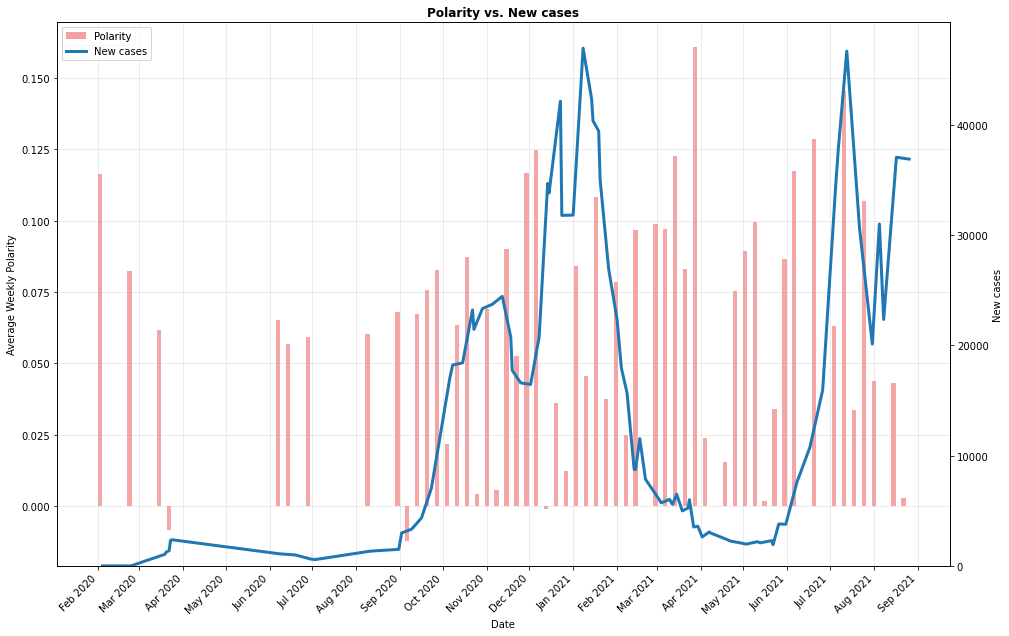

In [25]:
plot_polarity(column_name="newCasesBySpecimenDate", initial_date='2020-01-30', label="New cases")

/var/folders/pc/wdlmxwxj27d3wwj5bfsjlkbh0000gn/T/ipykernel_12159/3651017181.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


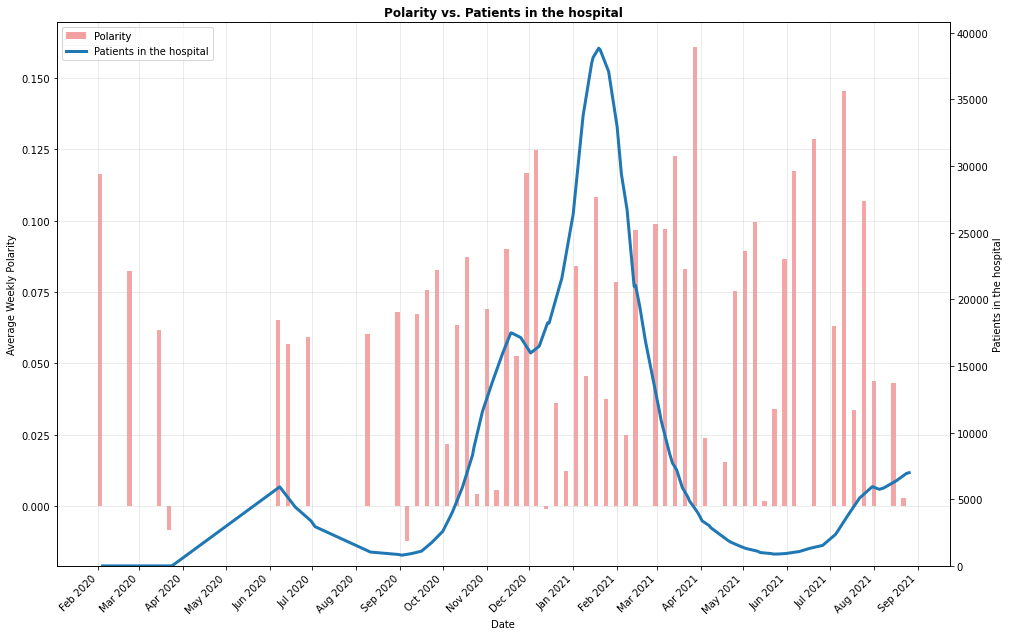

In [26]:
plot_polarity(column_name="hospitalCases", initial_date='2020-01-30', label="Patients in the hospital")

/var/folders/pc/wdlmxwxj27d3wwj5bfsjlkbh0000gn/T/ipykernel_12159/3651017181.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


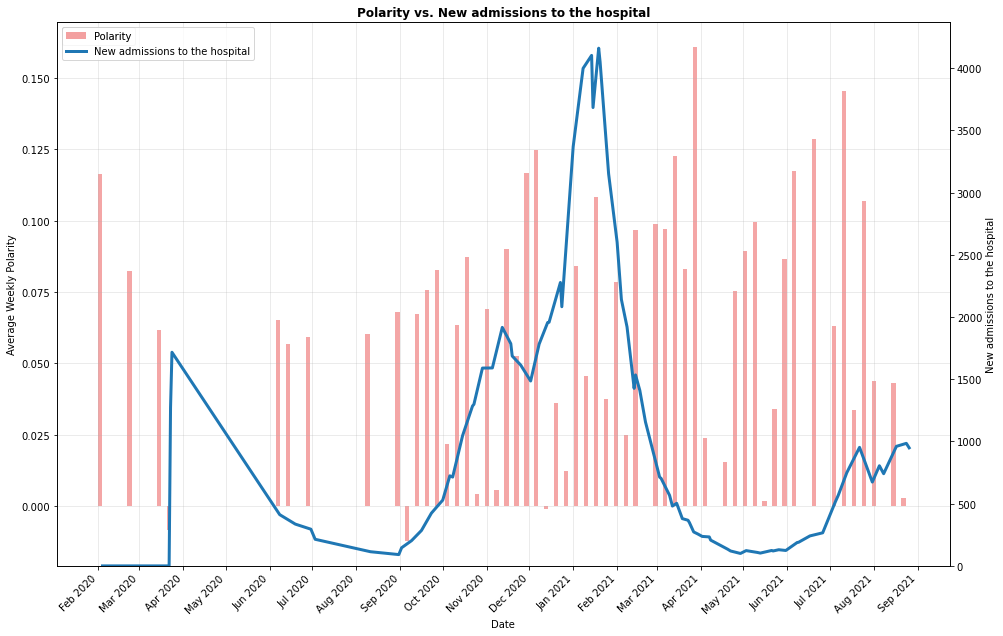

In [27]:
plot_polarity(column_name="newAdmissions", initial_date='2020-01-30', label="New admissions to the hospital")

/var/folders/pc/wdlmxwxj27d3wwj5bfsjlkbh0000gn/T/ipykernel_12159/3651017181.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


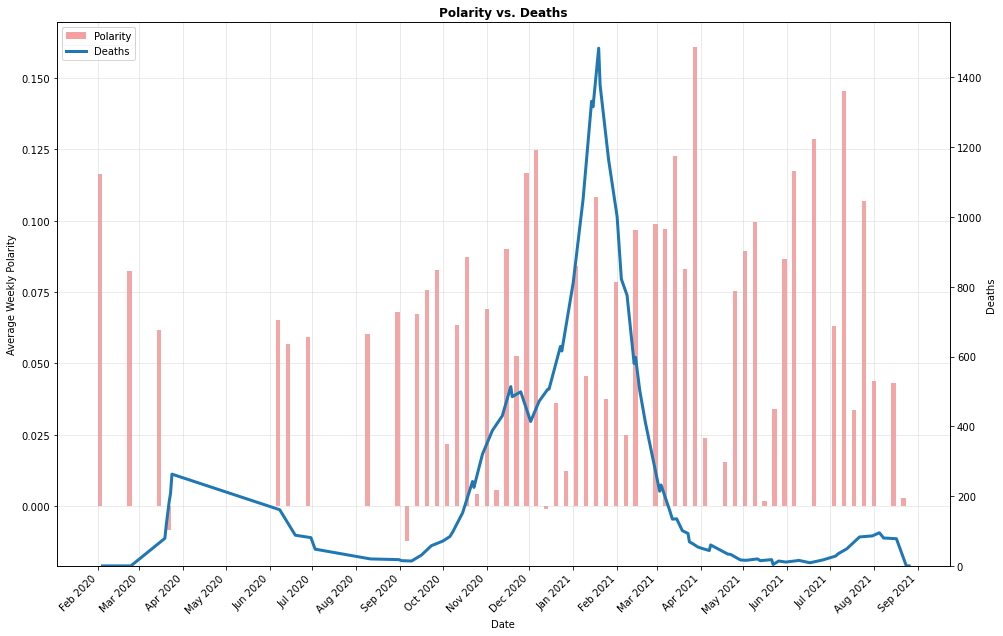

In [53]:
plot_polarity(column_name="newDailyNsoDeathsByDeathDate", initial_date='2020-01-30', label="Deaths")

/var/folders/pc/wdlmxwxj27d3wwj5bfsjlkbh0000gn/T/ipykernel_12159/3651017181.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


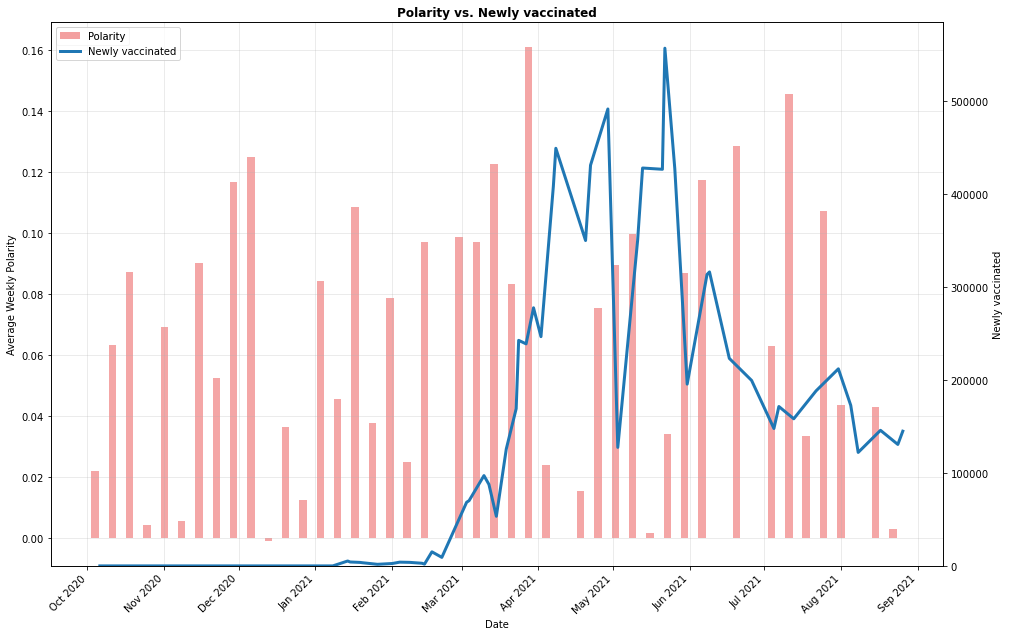

In [54]:
plot_polarity(column_name="newPeopleVaccinatedCompleteByPublishDate", initial_date='2020-10-01', label="Newly vaccinated")

There does not seem to exist any visible correlation between the Covid-19 metrics and the document polarity, but we can only test this via hypothesis testing.

## Hypothesis testing

We perform hypothesis testing using t-tests. We consider a result significant when it has a p-value smaller than or equal to 0.05. This will help us test our initial hypothesis that there is no significant change in the polarity of BBC articles since the pandemic started. 

We will also look into the influence of different pandemic metrics in the polarity, and whether there was significant change based on different arbitrary thresholds: for instance, if the daily deaths was higher than one thousand, does this affect polarity?

The first and most important test is whether the pandemic as a whole affected polarity. Our null hypothesis states that it did not.

In [30]:
final_df = final_df.sort_values(by='date')

In [31]:
# extract the mean polarity of the entire DataFrame for our t-tests below
population_mean = final_df.polarity.mean()

In [32]:
# First registered cases in the UK (by specimen date): January 30, 2020.

initial_date = datetime.strptime('2020-01-30', '%Y-%m-%d').date()
pandemic_polarity = final_df.query("date >= @initial_date", engine='python').polarity
tscore, pvalue = ttest_1samp(pandemic_polarity, popmean=population_mean)
print("t Statistic: ", tscore)  
print(f'p-value for single sided test: {pvalue / 2:.5f}')

t Statistic:  2.627836035653805
p-value for single sided test: 0.00510


As it turns out, the difference in polarity of articles in the pandemic is significant according to our test. The data compels us, therefore, to reject the null hypothesis. There was significant change, and it was positive, i.e. the articles published during the pandemic have a higher polarity than before the pandemic. We will problematize this result in the Conclusion.

Below we will look into the different pandemic metrics, and check whether we can find any significant variation in polarity there.

In [33]:
# define a function for the t-test in order to avoid repeating the code

def significance_test(df, query_string, label):
    data = df.query(query_string).polarity
    tscore, pvalue = ttest_1samp(data, popmean=population_mean)
    print(f'// {label} //')
    print("t Statistic: ", tscore)  
    print(f'p-value for single sided test: {pvalue / 2:.5f}\n')
    return

In [34]:
# New deaths

significance_test(final_df, "newDailyNsoDeathsByDeathDate > 100", "Days with more than 100 deaths in the UK")
significance_test(final_df, "newDailyNsoDeathsByDeathDate > 1000", "Days with more than 1000 deaths in the UK")

// Days with more than 100 deaths in the UK //
t Statistic:  1.6814986547937414
p-value for single sided test: 0.05033

// Days with more than 1000 deaths in the UK //
t Statistic:  1.1609434762237179
p-value for single sided test: 0.14488



Both tests show a non-significant increase in polarity in the arbitrary threshold we established for daily deaths.

In [35]:
# Vaccination coverage

significance_test(final_df, "newPeopleVaccinatedCompleteByPublishDate > 100000", 
                            "Days in which more than 100,000 people were vaccinated in the UK")

significance_test(final_df, "newPeopleVaccinatedCompleteByPublishDate > 400000", 
                            "Days in which more than 400,000 people were vaccinated in the UK")

// Days in which more than 100,000 people were vaccinated in the UK //
t Statistic:  1.9077300552782936
p-value for single sided test: 0.03286

// Days in which more than 400,000 people were vaccinated in the UK //
t Statistic:  -1.0704996448983706
p-value for single sided test: 0.15996



The test for people more than 100,000 newly vaccinated people was statistiscally significant, so we'd like to know the variation in the polarity means in this particular case. We see below it is 0.0208 (rounded to four decimal points). We will comment on the remaining significance tests at the end of the section.

In [36]:
print("Polarity diff:", round(final_df.query("newPeopleVaccinatedCompleteByPublishDate > 100000").polarity.mean() \
                                                              - final_df.polarity.mean(), 4))

Polarity diff: 0.0208


In [37]:
# Total patients in hospitals

significance_test(final_df, "hospitalCases > 1000", 
                            "Total patients in hospitals more than 1000 in the UK")

significance_test(final_df, "hospitalCases > 5000", 
                            "Total patients in hospitals more than 5000 in the UK")

// Total patients in hospitals more than 1000 in the UK //
t Statistic:  3.0045296065548506
p-value for single sided test: 0.00184

// Total patients in hospitals more than 5000 in the UK //
t Statistic:  1.8722453621768502
p-value for single sided test: 0.03399



In [38]:
# New hospital admissions

significance_test(final_df, "newAdmissions < 100", 
                            "Days in which less than 100 people were admitted to hospitals in the UK")

significance_test(final_df, "newAdmissions > 100", 
                            "Days in which more than 100 people were admitted to hospitals in the UK")

significance_test(final_df, "newAdmissions > 500", 
                            "Days in which more than 500 people were admitted to hospitals in the UK")

significance_test(final_df, "newAdmissions > 1000", 
                            "Days in which more than 1000 people were admitted to hospitals in the UK")

// Days in which less than 100 people were admitted to hospitals in the UK //
t Statistic:  -0.42187410453072827
p-value for single sided test: 0.33659

// Days in which more than 100 people were admitted to hospitals in the UK //
t Statistic:  2.2477073404813326
p-value for single sided test: 0.01371

// Days in which more than 500 people were admitted to hospitals in the UK //
t Statistic:  1.0657681757313473
p-value for single sided test: 0.14599

// Days in which more than 1000 people were admitted to hospitals in the UK //
t Statistic:  0.6410571197493471
p-value for single sided test: 0.26318



In [39]:
# New cases (by specimen date)

significance_test(final_df, "newCasesBySpecimenDate < 1000", 
                            "Days with less than 1,000 new infections in the UK")

significance_test(final_df, "newCasesBySpecimenDate > 1000", 
                            "Days with more than 1,000 new infections in the UK")

significance_test(final_df, "newCasesBySpecimenDate > 10000", 
                            "Days with more than 1,000 new infections in the UK")

significance_test(final_df, "newCasesBySpecimenDate < 100", 
                            "Days with less than 100 new infections in the UK")

// Days with less than 1,000 new infections in the UK //
t Statistic:  -0.43607375725570036
p-value for single sided test: 0.33142

// Days with more than 1,000 new infections in the UK //
t Statistic:  2.378702888500885
p-value for single sided test: 0.00988

// Days with more than 1,000 new infections in the UK //
t Statistic:  0.7910057331264464
p-value for single sided test: 0.21680

// Days with less than 100 new infections in the UK //
t Statistic:  -0.4472156111928524
p-value for single sided test: 0.32739



We have found that there is significance in the following metrics (higher document polarity):
- Days with more than 100,000 people vaccinated;
- Days with more than 1,000 and 5,000 people in the hospital due to Covid;
- Days with more than 100 people admitted to the hospital;
- Days with more than 1,000 new infections.

This can be due to different reasons, but the results are somehow counter-intuitive. We will leave this aside and approach the pandemic numbers in a different manner. We will look at the variation instead of absolute numbers. Pandas has a very useful function to calculate percentage change from one value to the next (`pct_change`).

In [40]:
# Pandas has a very useful function to calculate percentage change from one row to the next
variation_df = final_df.iloc[:, 1:].pct_change().fillna(0)
variation_df['date'] = final_df.iloc[:, 0]

In [41]:
variation_df.tail()

,polarity,hospitalCases,newAdmissions,newCasesBySpecimenDate,newDailyNsoDeathsByDeathDate,newPeopleVaccinatedCompleteByPublishDate,date
1589,0.195112,-0.034129,0.194362,0.541079,0.104651,-0.185469,2021-08-05
1590,-1.316953,0.017406,-0.079503,-0.279291,-0.157895,-0.293135,2021-08-08
1591,-2.062214,0.093755,0.296896,0.658184,-0.025000,0.195011,2021-08-17
1592,0.571510,0.084311,0.024974,-0.003641,-1.000000,-0.104192,2021-08-24
1593,-1.915764,0.009233,-0.036548,-0.000839,0.000000,0.109125,2021-08-26


In [42]:
variation_df.corr()

,polarity,hospitalCases,newAdmissions,newCasesBySpecimenDate,newDailyNsoDeathsByDeathDate,newPeopleVaccinatedCompleteByPublishDate
polarity,1.000000,-0.000777,-0.000824,-0.000768,-0.000913,-0.001245
hospitalCases,-0.000777,1.000000,0.757812,0.001195,0.525123,-0.178321
newAdmissions,-0.000824,0.757812,1.000000,0.002930,0.494144,-0.162885
newCasesBySpecimenDate,-0.000768,0.001195,0.002930,1.000000,0.399600,-0.000885
newDailyNsoDeathsByDeathDate,-0.000913,0.525123,0.494144,0.399600,1.000000,-0.116887
newPeopleVaccinatedCompleteByPublishDate,-0.001245,-0.178321,-0.162885,-0.000885,-0.116887,1.000000


In [43]:
# New deaths

significance_test(variation_df, "newDailyNsoDeathsByDeathDate < 0", 
                            "Days with less deaths than the previous time period")

significance_test(variation_df, "newDailyNsoDeathsByDeathDate > 0", 
                            "Days with more deaths than the previous time period")

significance_test(variation_df, "newDailyNsoDeathsByDeathDate > 0.2", 
                            "Days with more than 20% increase in deaths in relation to previous time period")

significance_test(variation_df, "newDailyNsoDeathsByDeathDate > 0.5", 
                            "Days with more than 50% increase in deaths in relation to previous time period")

significance_test(variation_df, "newDailyNsoDeathsByDeathDate > 1", 
                            "Days with more than 100% increase in deaths in relation to previous time period")

// Days with less deaths than the previous time period //
t Statistic:  -1.3161834904855854
p-value for single sided test: 0.09771

// Days with more deaths than the previous time period //
t Statistic:  -0.9920235226099539
p-value for single sided test: 0.16357

// Days with more than 20% increase in deaths in relation to previous time period //
t Statistic:  -0.9953281504539755
p-value for single sided test: 0.16497

// Days with more than 50% increase in deaths in relation to previous time period //
t Statistic:  -1.001992515070765
p-value for single sided test: 0.17126

// Days with more than 100% increase in deaths in relation to previous time period //
t Statistic:  -0.5557180812726384
p-value for single sided test: 0.31714



In [44]:
# Vaccination coverage

significance_test(variation_df, "newPeopleVaccinatedCompleteByPublishDate > 0", 
                            "Days with more people vaccinated than the previous time period")

significance_test(variation_df, "newPeopleVaccinatedCompleteByPublishDate > 0.2", 
                            "Days with more than 20% increase in vaccinations in relation to previous time period")

significance_test(variation_df, "newPeopleVaccinatedCompleteByPublishDate > 0.5", 
                            "Days with more than 50% increase in vaccinations in relation to previous time period")

// Days with more people vaccinated than the previous time period //
t Statistic:  -1.4169120550477878
p-value for single sided test: 0.08468

// Days with more than 20% increase in vaccinations in relation to previous time period //
t Statistic:  -1.42214904903236
p-value for single sided test: 0.08844

// Days with more than 50% increase in vaccinations in relation to previous time period //
t Statistic:  -0.9587566934999242
p-value for single sided test: 0.18288



In [45]:
# Total patients in hospitals

significance_test(variation_df, "hospitalCases < 0", 
                            "Days with less patients in hospitals than the previous time period")

significance_test(variation_df, "hospitalCases > 0", 
                            "Days with more patients in hospitals than the previous time period")

significance_test(variation_df, "hospitalCases > 0.2", 
                            "Days with more than 20% increase in patients in hospitals in relation to previous time period")

significance_test(variation_df, "hospitalCases > 0.5", 
                            "Days with more than 50% increase in patients in hospitals in relation to previous time period")

// Days with less patients in hospitals than the previous time period //
t Statistic:  -1.253096844208626
p-value for single sided test: 0.10882

// Days with more patients in hospitals than the previous time period //
t Statistic:  -0.9939901247048145
p-value for single sided test: 0.16326

// Days with more than 20% increase in patients in hospitals in relation to previous time period //
t Statistic:  0.6021975618211443
p-value for single sided test: 0.27913

// Days with more than 50% increase in patients in hospitals in relation to previous time period //
t Statistic:  -0.35567480856753986
p-value for single sided test: 0.37805



In [46]:
# New hospital admissions

significance_test(variation_df, "newAdmissions < 0", 
                        "Days in which less people were admitted to hospitals in relation to previous time period")

significance_test(variation_df, "newAdmissions > 0", 
                        "Days in which more people were admitted to hospitals in relation to previous time period")

significance_test(variation_df, "newAdmissions > 0.2", 
                        "Days with more than 20% increase in hospital admissions in relation to previous time period")

significance_test(variation_df, "newAdmissions > 0.5", 
                        "Days with more than 50% increase in hospital admissions in relation to previous time period")

// Days in which less people were admitted to hospitals in relation to previous time period //
t Statistic:  -0.5704351263413614
p-value for single sided test: 0.28571

// Days in which more people were admitted to hospitals in relation to previous time period //
t Statistic:  -0.9999827028300661
p-value for single sided test: 0.16191

// Days with more than 20% increase in hospital admissions in relation to previous time period //
t Statistic:  -2.4542926608162685
p-value for single sided test: 0.01170

// Days with more than 50% increase in hospital admissions in relation to previous time period //
t Statistic:  -1.8630386943466657
p-value for single sided test: 0.06796



In [47]:
# New cases

significance_test(variation_df, "newCasesBySpecimenDate < 0", 
                            "Days with less new infections than the previous time period")

significance_test(variation_df, "newCasesBySpecimenDate > 0", 
                            "Days with more new infections than the previous time period")

significance_test(variation_df, "newCasesBySpecimenDate > 0.2", 
                            "Days with more than 20% increase in new infections in relation to previous time period")

significance_test(variation_df, "newCasesBySpecimenDate > 0.5", 
                            "Days with more than 50% increase in new infections in relation to previous time period")

// Days with less new infections than the previous time period //
t Statistic:  -0.187392562066247
p-value for single sided test: 0.42615

// Days with more new infections than the previous time period //
t Statistic:  -1.0057668945475042
p-value for single sided test: 0.16008

// Days with more than 20% increase in new infections in relation to previous time period //
t Statistic:  -1.0101712247919852
p-value for single sided test: 0.16146

// Days with more than 50% increase in new infections in relation to previous time period //
t Statistic:  -1.0475221859743808
p-value for single sided test: 0.15775



We consider the approach of looking at the variation more reliable than looking at absolute numbers, and it also makes the process somehow less arbitrary (the variation is a normalized value). Only one test is significant: the polarity is lower in days in which there is at least 20% increase in hospital admissions in relation to the previous period.

## Conclusion

As demonstrated above, we rejected our null hypothesis. According to our data, the pandemic seems to have significantly increased the polarity in content published by BBC. This does not seem to have a clear explanation. On the other hand, when comparing the polarity with metrics from the pandemic, we have found that the polarity decreased in days in which the hospital admissions due to Covid increased by more than 20%.

Our results could be due to a few possible reasons. The first possiblity is that we did not have a big enough data set, and our data does not represent the population. This seems to be likely; it is difficult to stablish here how big is big enough for the sample to be safely regarded as representative of the population. Perhaps a better approach would be improving the `SitemapWebCrawler` class in order for it to crawl "random" URLs in each page (still constrained by the upper URL limite). An alternative could be running the Web Crawler from a cloud service, set a sleep time after a crawling some pages (for instance, waiting 1s after three requests), and get all the content. 

There is, of course, also the possibility that the pandemic does not generally reflect in the polarity of editorial news. We cannot ignore the fact that the BBC staff is comprised of professional writers, and therefore one might expect to find a smaller polarity variation than, e.g., in social media. An interesting alternative for looking at fluctuations in editorial news would be to collect data from a social network - preferably a more fast-paced one, such as Twitter or Reddit - in order to have a more granular time series that should have properties more relatable to real events than editorial news.